## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Defining and calling functions to test the imported initial image

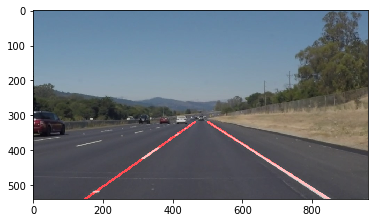

In [3]:
import math


def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#creating a gray copy of original image
gray_image=grayscale(image)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#applying gaussian blur
gaussian_blur_image=gaussian_blur(gray_image, 9)

#detecting edges via Canny function
canny_image=canny(gaussian_blur_image,50,150)


def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
#Defining four vertices for masking
vertices=np.array([[(40,image.shape[0]),(420, 320), (540, 320), (image.shape[1]-40,image.shape[0])]], dtype=np.int32)

#applying a mask
masked_image=region_of_interest(canny_image, vertices)


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
# The idea is to categorize slopes of hough_lines into positive and negative category. Then take an average of each group.
# Then assign positive averaged slope as slope of the left guide line and negative to the right line. By assuming each
# line equation to be y=mx+b, b is calculated by solving the line equation when passing throgh the mid point of the guide
# line. In order to calculate the mid point, all Xs and Ys contributing in hough_lines are called and an average point is calculated 
# as sum(all x)/(number of points) and the same for average y which is basically the mid point of upper edge of mask 
# and bottom of the image. This part of the code can be modified to be shorter. Time did not allow.
    left_slopes=[]
    right_slopes=[]
    x_left=[]
    y_left=[]
    x_right=[]
    y_right=[]
    #creating list of all hough lines start and end x and y and a list of line slopes and categorize them
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (y2-y1)/(x2-x1)>0:
                left_slopes.append((y2-y1)/(x2-x1))
                x_left.extend((x1,x2))
                y_left.extend((y1,y2))
                         
            if (y2-y1)/(x2-x1)<0:
                right_slopes.append((y2-y1)/(x2-x1))
                x_right.extend((x1,x2))
                y_right.extend((y1,y2))

    
    #finding x of upper and lower limit of left line
    if len(left_slopes)!=0:
        if len(x_left)!=0:
            if len(y_left)!=0:
                left_slope_average=sum(left_slopes)/len(left_slopes)
                b_left=(sum(y_left)/len(y_left))-left_slope_average*(sum(x_left)/len(x_left))
                x1_left=(320-b_left)/left_slope_average
                x2_left=(540-b_left)/left_slope_average
                cv2.line(img, (int(round(x1_left)), 320), (int(round(x2_left)), 540), color, thickness)
    
    #finding x of upper and lower limit of right line
    if len(right_slopes)!=0:
        if len(x_right)!=0:
            if len(y_right)!=0:
                right_slope_average=sum(right_slopes)/len(right_slopes)
                b_right=(sum(y_right)/len(y_right))-right_slope_average*(sum(x_right)/len(x_right))
                x1_right=(320-b_right)/right_slope_average
                x2_right=(540-b_right)/right_slope_average
                cv2.line(img, (int(round(x1_right)), 320), (int(round(x2_right)), 540), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

#applying hough lines to the image
rho=1
theta=np.pi/180
threshold=50
min_line_len=100
max_line_gap=160
hough_line_image=hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

#creating the final image by imposing the processed image over the original one
final_image=weighted_img(hough_line_image, image)
plt.imshow(final_image, cmap='gray')


# Importing test images from test image directory

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

# Building a Lane Finding Pipeline



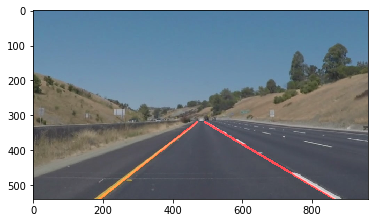

In [5]:
list=os.listdir("test_images/")
if os.path.isdir("test_images_output/")==False:
    os.makedirs("test_images_output/")
    
#start processing all the images in the folder
for i in range(len(os.listdir("test_images/"))):
    path=os.path.join('test_images/',list[i])
    image = mpimg.imread(path)
    
    #creating gray image
    gray_image=grayscale(image)
    
    #applying blur
    gaussian_blur_image=gaussian_blur(gray_image, 9)
    
    #applying canny
    canny_image=canny(gaussian_blur_image,50,150)
    
    #isolating region of interest
    vertices=np.array([[(170,image.shape[0]-50),(420, 320), (540, 320), (image.shape[1]-170,image.shape[0]-50)]], dtype=np.int32)
    masked_image=region_of_interest(canny_image, vertices)
    
    #creating hough lines and calculating and drawing fitting lines
    rho=1
    theta=np.pi/180
    threshold=50
    min_line_len=5
    max_line_gap=1
    hough_line_image=hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
    
    #combining processed image with the original image and plotting it
    final_image=weighted_img(hough_line_image, image)
    plt.imshow(final_image, cmap='gray')
    
    #saving a new copy of final image in a new folder
    img_complete_name=os.path.join('test_images_output/',os.listdir("test_images/")[i])
    saved_img=cv2.imwrite(img_complete_name,final_image)

    

# Test on Videos


In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    
    #creating gray image
    gray_image=grayscale(image)

    #applying blur
    gaussian_blur_image=gaussian_blur(gray_image, 9)

    #applying canny
    canny_image=canny(gaussian_blur_image,50,150)

    #isolating region of interest
    vertices=np.array([[(10,image.shape[0]),(420, 320), (540, 320), (image.shape[1]-10,image.shape[0])]], dtype=np.int32)
    masked_image=region_of_interest(canny_image, vertices)

    #creating hough lines and calculating and drawing fitting lines
    rho=1
    theta=np.pi/180
    threshold=50
    min_line_len=5
    max_line_gap=1
    hough_line_image=hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)

    #combining processed image with the original image and plotting it
    final_image=weighted_img(hough_line_image, image)
    result=final_image
    return result

In [8]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
#clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████████████████████████████████████████████████████████████▋| 221/222 [00:07<00:00, 26.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 9.06 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████████████████████████████████████████████████████████████▉| 681/682 [00:24<00:00, 29.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 25.4 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Challenge 
The following result is from running the same code which was used to create the last two videos. My initial idea is that region of interest has to be remasked in order to resolve the issue with the challenge video.

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████████████████████████████████████████████████████████████| 251/251 [00:17<00:00, 14.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 19.8 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))